In [26]:
import numpy as np
import math 
import random
from qiskit import QuantumCircuit, transpile, assemble, execute, IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel

In [27]:
one_q_gates = ['h', 'x', 'y', 'z']
multi_q_gates = ['cnot']

In [28]:
total_qubits = 5 # default of 5
circuits=[]

In [29]:
# This function adds a cycle to a given circuit 
def add_cycle(circ, has_cnot=True, add_barrier=False):
    new_circ = QuantumCircuit(total_qubits)
    qasm_str = circ.qasm()
    new_qasm_str = ""
    filled_qubit=0
    while filled_qubit < total_qubits:
        chosen_one_q_gate = random.choice(one_q_gates)
        add_single_q = chosen_one_q_gate + " q[" + str(filled_qubit) + "];\n"
        new_qasm_str += add_single_q
        
        # increment to next qubit to fill for this cycle
        filled_qubit+=1
        
        # increment to next cycle once all qubits are filled
        if filled_qubit == total_qubits:
            chosen_q = [i for i in range(total_qubits)]
            fill_rand_q = random.choice(chosen_q)
            chosen_q.remove(fill_rand_q)
            fill_rand_q2= random.choice(chosen_q)
            add_cnot = 'cx q[' + str(fill_rand_q) + '],q[' + str(fill_rand_q2) + '];\n'
            new_qasm_str += add_cnot
            
            if add_barrier:
                apply_to_all_q = ["q["+ str(i) +"]" for i in range(total_qubits)]
                apply_to_all_q = ','.join(apply_to_all_q)
                new_qasm_str += 'barrier ' + apply_to_all_q + ';\n'
    
    # Add new circuit cycle instruction to old circuit 
    qasm_str += new_qasm_str
    
    new_circ = new_circ.from_qasm_str(qasm_str)
    
    # Return new circuit layout with new cycle
    return new_circ

def remove_measure(circ):
    new_circ = QuantumCircuit(total_qubits)
    qasm_str = circ.qasm()
    qasm_list = qasm_str.split('\n')[:-6]
    new_qasm_str = '\n'.join(qasm_list)
    new_circ = new_circ.from_qasm_str(new_qasm_str)
    # Return circuit without measure
    return new_circ


# This function generates a random circuit given a circuit depth
def generate_random_circuit(circuit_depth, add_barrier=False):
    circ = QuantumCircuit(total_qubits) 
    current_cycle=0
    while current_cycle < circuit_depth:
        if current_cycle < circuit_depth-1:
            circ = add_cycle(circ, add_barrier=add_barrier)
        else:
            circ = add_cycle(circ, add_barrier=add_barrier)
        current_cycle+=1
        
    return circ

In [30]:
#### CREATE RANDOM CIRCUIT ###
# total_qubits = 5
# dummy_circ = generate_random_circuit(1, True) # generate random circuit of 5 qubits, circuit depth of 1

In [31]:
# circ.measure_all()
# circ.draw("mpl")

In [84]:
total_qubits = 5
dummy_circ = generate_random_circuit(1, True) # generate random circuit of 5 qubits, circuit depth of 1
circuits.append(dummy_circ)

incre = 5
times = 40
for j in range(times):
    for i in range(incre):
        dummy_circ=add_cycle(dummy_circ, add_barrier=True) # manually add cycles
    circuits.append(dummy_circ)

# add measure
for circ in circuits:
    circ.measure_all()
    
print(circuits)
print(len(circuits))

[<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac76ef9700>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac757a0400>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac78f52070>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac758c5250>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac76c8b400>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac75b01460>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac75c5f1c0>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac78f35820>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac758c1340>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac758a2670>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac75b9ad00>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac75c9e460>, <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7fac76ef9a90>, <qiskit.circuit.quantumcircuit.QuantumCircuit obje

In [44]:
# run on QASM Simulator 
# transpile quantum circuit to low-level QASM instructions for backend
# execute the circuit on the qasm simulator, given number of shots (run repeats)
Ls = []
Es = []
counts_per_circuit = []
for circ in circuits:
    run_circ = circ
    qasm_sim = QasmSimulator()
    shots = 1024
    qc_compiled = transpile(run_circ, qasm_sim) 

    job_sim = qasm_sim.run(qc_compiled, shots=shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc_compiled)
    counts_per_circuit.append(counts)

201


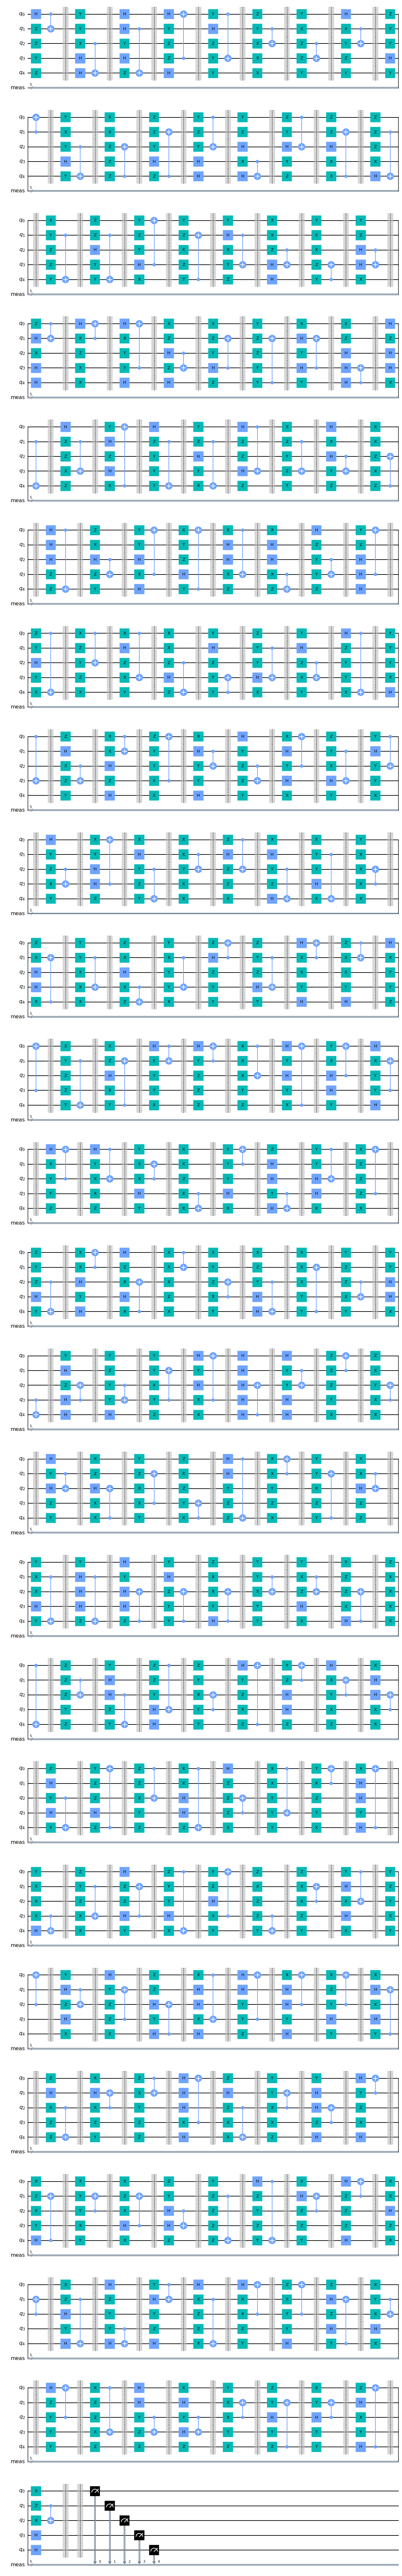

In [52]:
circ_num = len(circuits)-1
print((circ_num*incre) + 1)
circuits[circ_num].draw("mpl")

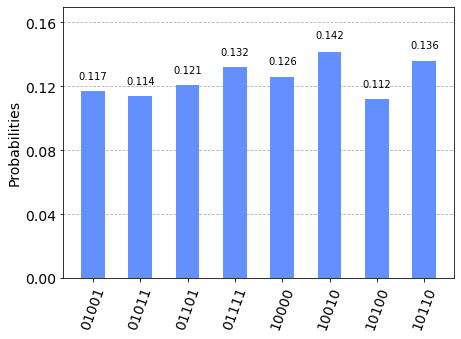

In [49]:
counts=counts_per_circuit[circ_num]

#### HISTOGRAM ####
plot_histogram(counts)

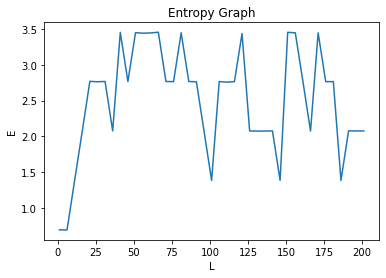

In [50]:
#### CALCULATING ENTROPY ####
from math import log

Ls = []
Es = []

for cn in range(len(circuits)):
    counts=counts_per_circuit[cn]
    L = (cn*incre) + 1
    # entropy of L in QASM Simulation
    qasm_entropy = []
    for k,v in counts.items():
        p = v/shots
        fn = p * log(p)
        qasm_entropy.append(fn)

    final_qasm_entropy = -sum(qasm_entropy)
#     print('QASM Entropy = ', final_qasm_entropy)
#     print('QASM L =', L)
    Ls.append(L)
    Es.append(final_qasm_entropy)

import matplotlib.pyplot as plt

plt.xlabel('L')
plt.ylabel('E')
plt.title('Entropy Graph')
plt.plot(Ls,Es, color='tab:blue')
plt.show()

In [37]:
provider=IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
# show options for backends

[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_stabilizer') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_m

In [38]:
ibmq_backend = provider.get_backend('ibmq_quito')
noise_model = NoiseModel.from_backend(ibmq_backend)

In [61]:
counts_per_tr_circ=[]
for cn in range(len(circuits)): 
    transpiled_circ=transpile(circuits[cn], ibmq_backend, optimization_level=3)
    sim_job = execute(transpiled_circ, qasm_sim, shots=shots, noise_model=noise_model)
    sim_result = sim_job.result()
    sim_counts = sim_result.get_counts()
    counts_per_tr_circ.append(sim_counts)
print(counts_per_tr_circ)

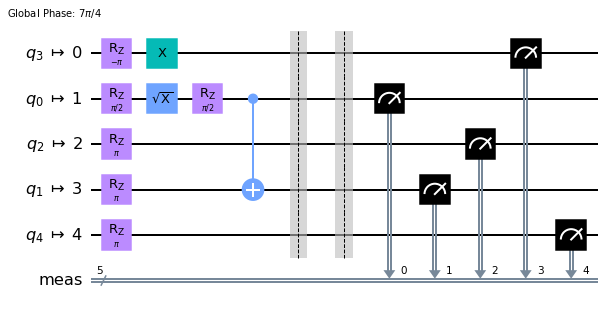

In [83]:
transpiled_circ=transpile(circuits[0], ibmq_backend, optimization_level=3)
transpiled_circ.draw("mpl")

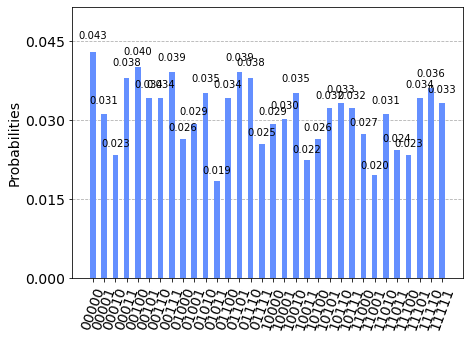

In [79]:
#### HISTOGRAM ####
plot_histogram(counts_per_tr_circ[40])

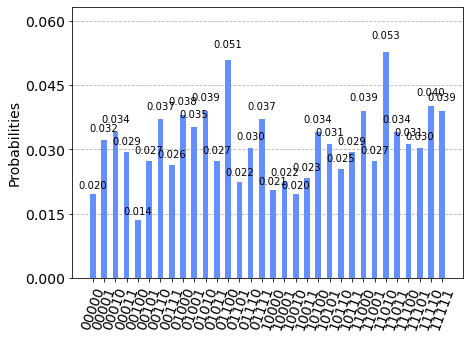

In [68]:
transpiled_circ_real=transpile(circuits[11], ibmq_backend, optimization_level=3)
real_job = execute(transpiled_circ_real, ibmq_backend, shots=shots)
real_result = real_job.result()
real_counts = real_result.get_counts()

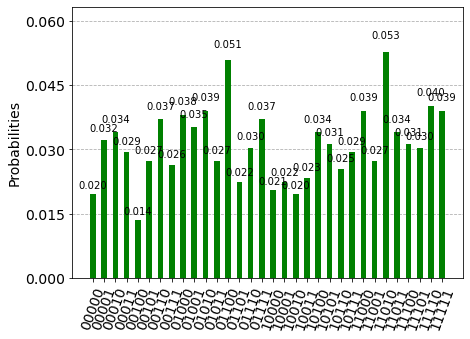

In [73]:
plot_histogram(real_counts, color='green')

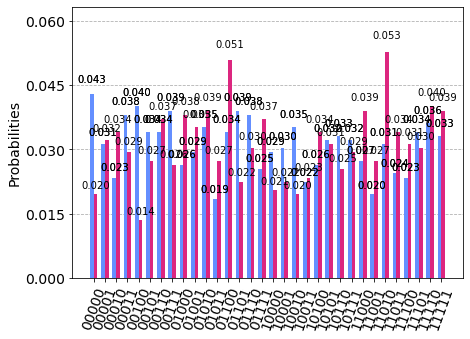

In [71]:
plot_histogram([sim_counts, real_counts])

In [ ]:
# OPTIONAL
# observe job, see if it is running or finished
from qiskit.tools.monitor import job_monitor
job_monitor(real_job)

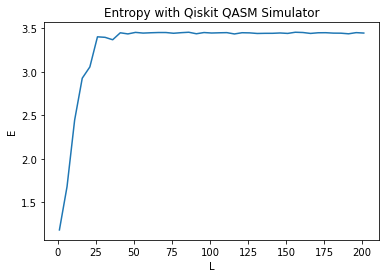

In [82]:
# from math import log

# L = (circ_num*incre) + 1

# # entropy of L in IMBQ Quito
# ibmq_qasm_entropy = []
# for k,v in sim_counts.items():
#     p = v/shots
#     fn = p * log(p)
#     ibmq_qasm_entropy.append(fn)

# final_ibmq_qasm_entropy = -sum(ibmq_qasm_entropy)
# print('IBM Q Entropy = ', final_ibmq_qasm_entropy)
# print('IBM Q Entropy L =', L)

#### CALCULATING ENTROPY ####
from math import log

Ls = []
Es = []

for cn in range(len(circuits)):
    counts=counts_per_tr_circ[cn]
    L = (cn*incre) + 1
    # entropy of L in QASM Simulation
    ibmqasm_entropy = []
    for k,v in counts.items():
        p = v/shots
        fn = p * log(p)
        ibmqasm_entropy.append(fn)

    final_ibmqasm_entropy = -sum(ibmqasm_entropy)
    Ls.append(L)
    Es.append(final_ibmqasm_entropy)

import matplotlib.pyplot as plt

plt.xlabel('L')
plt.ylabel('E')
plt.title('Entropy with Qiskit QASM Simulator')
plt.plot(Ls,Es, color='tab:blue')
plt.show()

In [70]:
from math import log

L = (11*incre) + 1

# entropy of L in IMBQ Quito
ibmq_entropy = []
for k,v in real_counts.items():
    p = v/shots
    fn = p * log(p)
    ibmq_entropy.append(fn)


final_ibmq_entropy = -sum(ibmq_entropy)
print('IBM Q Entropy = ', final_ibmq_entropy)
print('IBM Q Entropy L =', L)

IBM Q Entropy =  3.4290921635983223
IBM Q Entropy L = 56
